# Parkinson's Disease Detection (PAK DE)

## Persiapan

### Import Library

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 899.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# --- Libraries yang digunakan ---
import os
import pathlib
import random
import shutil
import zipfile

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from google.colab import files, drive

# --- Mengimpor libraries untuk visualisasi ---
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# --- Mengimpor libraries untuk pemrosesan data gambar ---
from PIL import Image

# --- Mengimpor libraries untuk pembuatan dan evaluasi model ---
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# --- Mengabaikan peringatan ---
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading Data

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Path ke folder dataset di Google Drive
drive_path = '/content/drive/MyDrive/'
project_folder = 'capstone_project'
dataset_path = os.path.join(drive_path, project_folder)
zip_file_name = 'parkinson_images.zip'
zip_file_path = os.path.join(dataset_path, zip_file_name)

# Direktori tujuan untuk mengesktrak isi zip (tetap di folder project)
extraction_path = dataset_path

print(f"Mencoba mengekstrak: '{zip_file_path}' ke '{extraction_path}'")

if os.path.exists(zip_file_path):
    !unzip '{zip_file_path}' -d '{extraction_path}'
    print(f"\nFile '{zip_file_name}' berhasil diesktrak ke: {extraction_path}")
else:
    print(f"File '{zip_file_name}' tidak ditemukan di: {zip_file_path}")

Mencoba mengekstrak: '/content/drive/MyDrive/capstone_project/parkinson_images.zip' ke '/content/drive/MyDrive/capstone_project'
Archive:  /content/drive/MyDrive/capstone_project/parkinson_images.zip
   creating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/
   creating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/spiral/
   creating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/spiral/testing/
   creating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/spiral/testing/healthy/
  inflating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/spiral/testing/healthy/V01HE01.png  
  inflating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/spiral/testing/healthy/V02HE01.png  
  inflating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/spiral/testing/healthy/V03HE1.png  
  inflating: /content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/spiral/te

In [7]:
# Menghapus file zip setelah berhasil diesktrak
try:
  os.remove(zip_file_path)
  print(f"File '{zip_file_name} berhasil dihapus dari {dataset_path}")
except FileNotFoundError:
  print(f"File '{zip_file_name}' tidak ditemukan di: {dataset_path}")
except Exception as e:
  print(f"Terjadi kesalahan saat menghapus file: {e}")

print(f"Isi dari '{zip_file_name}' berhasil diekstrak ke: {extraction_path}")

File 'parkinson_images.zip berhasil dihapus dari /content/drive/MyDrive/capstone_project
Isi dari 'parkinson_images.zip' berhasil diekstrak ke: /content/drive/MyDrive/capstone_project


## Data Understanding

### Plot Gambar Sample untuk Semua Kelas

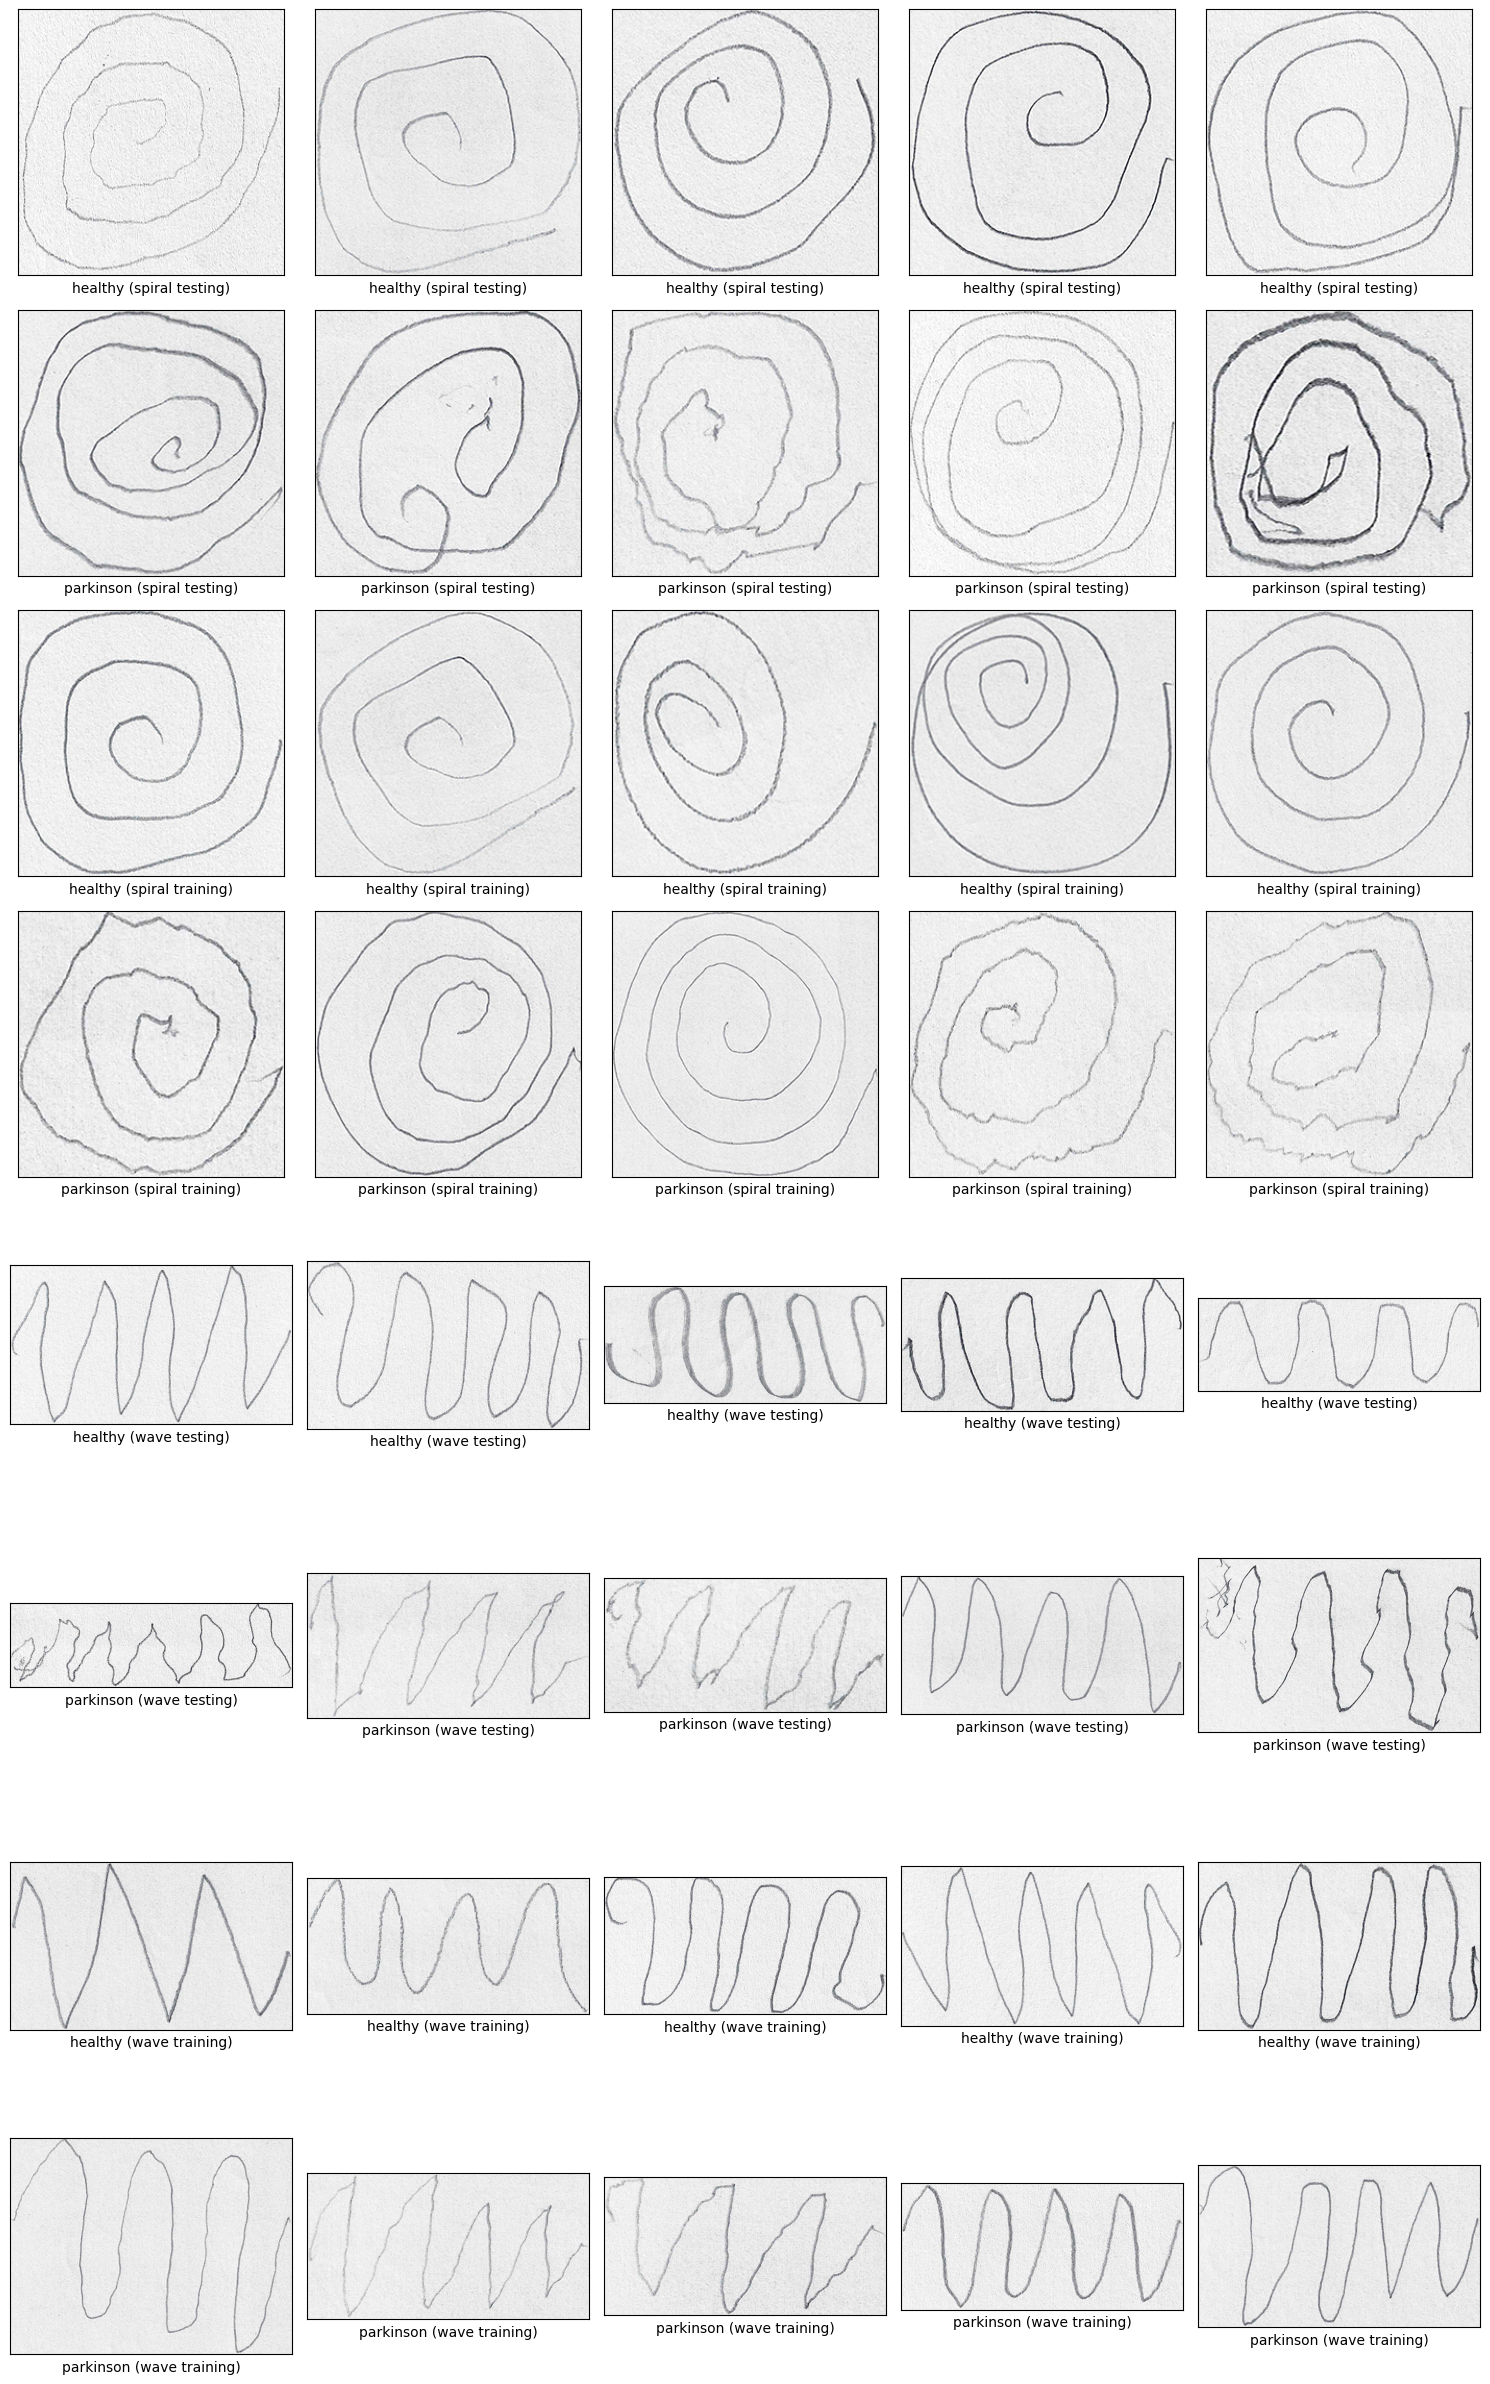

In [10]:
# Path ke direktori utama dataset
dataset_dir = '/content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/'
num_samples = 5  # Jumlah gambar yang ingin ditampilkan per kelas

sub_folders = ['spiral/testing', 'spiral/training', 'wave/testing', 'wave/training']
categories = ['healthy', 'parkinson']
all_data = {}

for sub_folder in sub_folders:
    for category in categories:
        folder_path = os.path.join(dataset_dir, sub_folder, category)
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            if image_files:
                key_name = f"{category} ({sub_folder.replace('/', ' ')})"
                all_data[key_name] = image_files
            else:
                print(f"Tidak ada gambar ditemukan di: {folder_path}")
        else:
            print(f"Folder tidak ditemukan: {folder_path}")

num_rows = len(all_data)
if num_rows > 0:
    fig, axs = plt.subplots(num_rows, num_samples, figsize=(15, 3 * num_rows))
    if num_rows == 1:
        axs = [axs]  # Handle kasus hanya satu baris

    for i, (class_name, image_list) in enumerate(all_data.items()):
        images = np.random.choice(image_list, min(num_samples, len(image_list)), replace=False)
        for j, image_name in enumerate(images):
            img_path = os.path.join(dataset_dir, sub_folders[0].split('/')[0] if 'spiral' in class_name else sub_folders[2].split('/')[0], sub_folders[0].split('/')[1] if 'testing' in class_name and 'spiral' in class_name or 'testing' in class_name and 'wave' in class_name else sub_folders[1].split('/')[1] if 'training' in class_name and 'spiral' in class_name or 'training' in class_name and 'wave' in class_name else '', class_name.split(' ')[0], image_name)

            # memperbaiki path
            parts = class_name.split(' (')
            condition = parts[1][:-1].replace(' ', '/')
            base_folder = 'spiral' if 'spiral' in class_name else 'wave'
            img_path = os.path.join(dataset_dir, condition, parts[0], image_name)


            try:
                img = Image.open(img_path).convert("RGB")
                axs[i, j].imshow(img)
                axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
            except FileNotFoundError:
                print(f"File tidak ditemukan: {img_path}")
                axs[i, j].set_title("File Not Found")
            except Exception as e:
                print(f"Gagal membuka gambar: {img_path} - {e}")
                axs[i, j].set_title("Error")

    fig.tight_layout()
    plt.show()
else:
    print("Tidak ada data gambar yang ditemukan.")

### Plot Distribusi Gambar di Seluruh Kelas

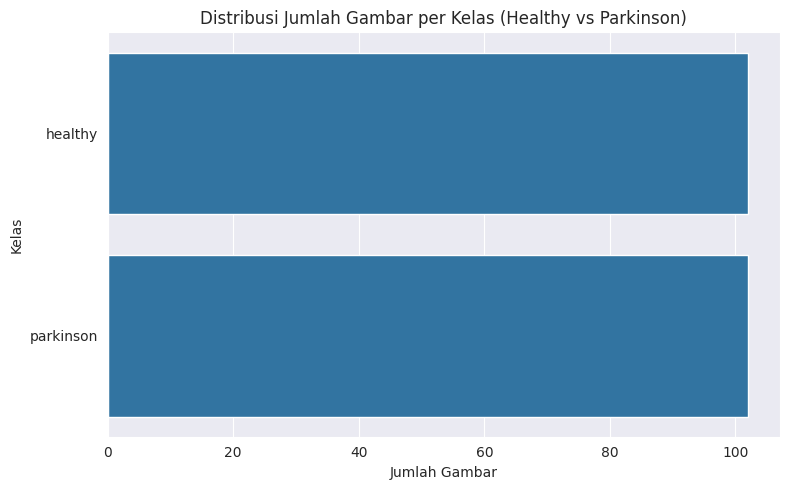


Jumlah Gambar per Kelas (Healthy vs Parkinson):
labels
healthy      102
parkinson    102
Name: count, dtype: int64


In [11]:
# Path ke direktori utama dataset yang berisi 'spiral' dan 'wave'
dataset_dir = '/content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset/'

# Membuat list untuk menyimpan nama file, path lengkap, dan label
file_name = []
labels = []
full_path = []

# Mengumpulkan nama file, path lengkap, dan label dari setiap gambar
for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Hanya memproses file gambar
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

# Membuat DataFrame dari data yang terkumpul
distribution = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Filter DataFrame hanya untuk label 'healthy' dan 'parkinson'
distribution_filtered = distribution[distribution['labels'].isin(['healthy', 'parkinson'])]

# Menghitung jumlah gambar per kelas
label_counts = distribution_filtered['labels'].value_counts().sort_values(ascending=False)

# Plot distribusi untuk kelas 'healthy' dan 'parkinson'
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution_filtered, order=label_counts.index)
plt.title('Distribusi Jumlah Gambar per Kelas (Healthy vs Parkinson)')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

print("\nJumlah Gambar per Kelas (Healthy vs Parkinson):")
print(label_counts)

## Data Preprocessing

### Split Dataset

In [12]:
# Path ke folder dataset utama
dataset_dir = '/content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset'
train_dir_spiral = os.path.join(dataset_dir, 'spiral', 'training')
train_dir_wave = os.path.join(dataset_dir, 'wave', 'training')
val_dir_spiral = os.path.join(dataset_dir, 'spiral', 'validation')
val_dir_wave = os.path.join(dataset_dir, 'wave', 'validation')

validation_ratio = 0.2

# Membuat folder validasi untuk spiral jika belum ada
if not os.path.exists(val_dir_spiral):
    os.makedirs(val_dir_spiral)
    os.makedirs(os.path.join(val_dir_spiral, 'healthy'))
    os.makedirs(os.path.join(val_dir_spiral, 'parkinson'))

# Membuat folder validasi untuk wave jika belum ada
if not os.path.exists(val_dir_wave):
    os.makedirs(val_dir_wave)
    os.makedirs(os.path.join(val_dir_wave, 'healthy'))
    os.makedirs(os.path.join(val_dir_wave, 'parkinson'))

# Proses pembagian data validasi untuk spiral
print("Memproses data spiral...")
for class_name in ['healthy', 'parkinson']:
    train_class_dir = os.path.join(train_dir_spiral, class_name)
    val_class_dir = os.path.join(val_dir_spiral, class_name)

    if os.path.isdir(train_class_dir):
        image_files = [f for f in os.listdir(train_class_dir) if os.path.isfile(os.path.join(train_class_dir, f))]
        num_images = len(image_files)
        num_val = int(num_images * validation_ratio)

        if num_val > 0:
            images_to_move = random.sample(image_files, num_val)
            for image_name in images_to_move:
                src_path = os.path.join(train_class_dir, image_name)
                dst_path = os.path.join(val_class_dir, image_name)
                shutil.move(src_path, dst_path)
            print(f"Memindahkan {num_val} gambar dari '{class_name}' (spiral training) ke validasi.")
        else:
            print(f"Tidak cukup gambar di '{class_name}' (spiral training) untuk validasi.")

# Proses pembagian data validasi untuk wave
print("\nMemproses data wave...")
for class_name in ['healthy', 'parkinson']:
    train_class_dir = os.path.join(train_dir_wave, class_name)
    val_class_dir = os.path.join(val_dir_wave, class_name)

    if os.path.isdir(train_class_dir):
        image_files = [f for f in os.listdir(train_class_dir) if os.path.isfile(os.path.join(train_class_dir, f))]
        num_images = len(image_files)
        num_val = int(num_images * validation_ratio)

        if num_val > 0:
            images_to_move = random.sample(image_files, num_val)
            for image_name in images_to_move:
                src_path = os.path.join(train_class_dir, image_name)
                dst_path = os.path.join(val_class_dir, image_name)
                shutil.move(src_path, dst_path)
            print(f"Memindahkan {num_val} gambar dari '{class_name}' (wave training) ke validasi.")
        else:
            print(f"Tidak cukup gambar di '{class_name}' (wave training) untuk validasi.")

print("\nProses pembuatan folder validasi selesai.")

Memproses data spiral...
Memindahkan 7 gambar dari 'healthy' (spiral training) ke validasi.
Memindahkan 7 gambar dari 'parkinson' (spiral training) ke validasi.

Memproses data wave...
Memindahkan 7 gambar dari 'healthy' (wave training) ke validasi.
Memindahkan 7 gambar dari 'parkinson' (wave training) ke validasi.

Proses pembuatan folder validasi selesai.


## Data Augmentation

In [13]:
# Path ke direktori utama dataset
base_dir = '/content/drive/MyDrive/capstone_project/Parkinson Dataset/dataset'
train_dir = os.path.join(base_dir, 'spiral', 'training')
val_dir_spiral = os.path.join(base_dir, 'spiral', 'validation') # Kita buat sebelumnya
test_dir_spiral = os.path.join(base_dir, 'spiral', 'testing')

train_datagen_spiral = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen_spiral = ImageDataGenerator(rescale=1./255)
test_datagen_spiral = ImageDataGenerator(rescale=1./255)

train_generator_spiral = train_datagen_spiral.flow_from_directory(
    train_dir_spiral,
    target_size=(128, 128),  # Sesuaikan ukuran target
    batch_size=32,
    class_mode='binary'      # Karena kita punya kelas healthy dan parkinson
)

validation_generator_spiral = val_datagen_spiral.flow_from_directory(
    val_dir_spiral,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator_spiral = test_datagen_spiral.flow_from_directory(
    test_dir_spiral,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("\nGenerator Spiral:")
print("Label kelas training:", train_generator_spiral.class_indices)
print("Jumlah batch training:", len(train_generator_spiral))
print("Jumlah batch validasi:", len(validation_generator_spiral))
print("Jumlah batch testing:", len(test_generator_spiral))

# Ulangi proses yang sama untuk data 'wave'
train_dir_wave = os.path.join(base_dir, 'wave', 'training')
val_dir_wave = os.path.join(base_dir, 'wave', 'validation') # Kita buat sebelumnya
test_dir_wave = os.path.join(base_dir, 'wave', 'testing')

train_datagen_wave = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen_wave = ImageDataGenerator(rescale=1./255)
test_datagen_wave = ImageDataGenerator(rescale=1./255)

train_generator_wave = train_datagen_wave.flow_from_directory(
    train_dir_wave,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

validation_generator_wave = val_datagen_wave.flow_from_directory(
    val_dir_wave,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator_wave = test_datagen_wave.flow_from_directory(
    test_dir_wave,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("\nGenerator Wave:")
print("Label kelas training:", train_generator_wave.class_indices)
print("Jumlah batch training:", len(train_generator_wave))
print("Jumlah batch validasi:", len(validation_generator_wave))
print("Jumlah batch testing:", len(test_generator_wave))

Found 58 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 30 images belonging to 2 classes.

Generator Spiral:
Label kelas training: {'healthy': 0, 'parkinson': 1}
Jumlah batch training: 2
Jumlah batch validasi: 1
Jumlah batch testing: 1
Found 58 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 30 images belonging to 2 classes.

Generator Wave:
Label kelas training: {'healthy': 0, 'parkinson': 1}
Jumlah batch training: 2
Jumlah batch validasi: 1
Jumlah batch testing: 1


**Source**

[Parkinson Dataset](https://data.mendeley.com/datasets/fd5wd6wmdj/1)